In [1]:
from collections import Counter
import json
from pathlib import Path
from statistics import mean

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from ml_filter.analysis.utils import get_document_scores_df

In [2]:
human_annotations_file = Path("/raid/s3/opengptx/user/richard-rutmann/data/eurolingua/prompt_based_annotations/test_data/gt/annotations__educational_content__en__gt.jsonl")
output_dir = Path("/raid/s3/opengptx/user/richard-rutmann/data/eurolingua/prompt_based_annotations/test_data/gt/plots")
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
def most_frequent_average(values: list[int]) -> float:
    """
    Finds the most frequent value(s) in a list. If there are ties, returns the average of the tied values.

    Args:
        values (list): A list of values (can be integers, floats, etc.) to analyze.

    Returns:
        float: The most frequent value, or the average of the most frequent values if there is a tie.

    Example:
        >>> values = [4, 2, 2, 3, 3, 5]
        >>> most_frequent_average(values)
        2.5
    """

    counts = Counter(values)
    max_frequency = max(counts.values())
    most_frequent_values = [key for key, val in counts.items() if val == max_frequency]
    return sum(most_frequent_values) / len(most_frequent_values)


In [4]:
def load_human_annotations(
    annotation_file: Path,
    aggregation_strategy: str,
) -> dict[str, dict[str, float]]:
    """
    Extracts the scores and corresponding document ids from a set of jsonl-files.
    Documents which do not have a score for each annotator are excluded.

    Args:
        annotation_file (Path): Path to file with human annotations.
        aggregation_strategy (str, optional): Specifies how scores for a document from the same file are aggregated.
            Supported values:
            - "mean": Compute the average score.
            - "max": Use the maximum score.
            - "min": Use the minimum score.
            - "majority": Use the score that was voted the most. If there is a tie, take the average of the winners.

    Raises:
        ValueError: If invalid parameter combinations are provided.

    Returns:
        None
    """
    document_scores = []

    # Read the JSONL file and extract scores for each document
    with open(annotation_file, "r") as f:
        for line in f:
            json_obj = json.loads(line)
            scores = [float(score) for score in json_obj.get("scores")]

            # aggregate scores for each document
            if aggregation_strategy == "min":
                aggregated_score = min(scores)
            elif aggregation_strategy == "max":
                aggregated_score = max(scores)
            elif aggregation_strategy == "mean":
                aggregated_score = mean(scores)
            elif aggregation_strategy == "majority":
                aggregated_score = most_frequent_average(scores)
            else:
                raise NotImplementedError(f"Aggregation type {aggregation_strategy} is not supported.")

            document_scores.append(
                {
                    "doc_id": json_obj.get("document_id"),
                    "score": aggregated_score,
                }
            )

    document_scores_df = pd.DataFrame(document_scores)
    return document_scores_df

In [5]:
human_annotations_df = load_human_annotations(human_annotations_file, aggregation_strategy="majority")
human_annotations_df.head()

,doc_id,score
0,0,2.000000
1,1,3.000000
2,2,1.666667
3,3,0.000000
4,4,0.000000


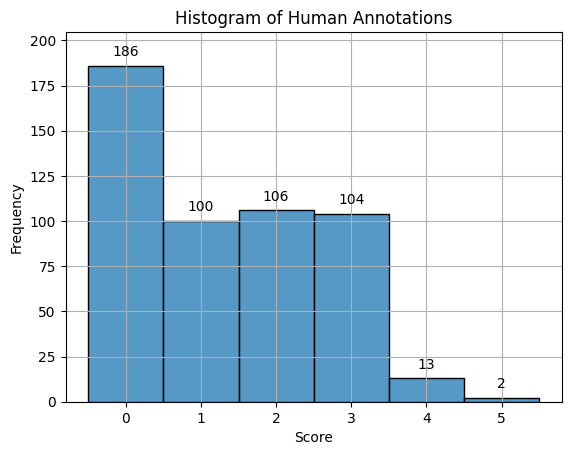

In [6]:

# Define bin edges to center bins around integers 0 to 5
bin_edges = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

# Plot the "score" column as a histogram using Seaborn
ax = sns.histplot(data=human_annotations_df, x="score", bins=bin_edges, kde=False, edgecolor="black", discrete=True)
plt.title("Histogram of Human Annotations")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.xticks(range(6))  # Set x-axis ticks to integers 0 to 5
plt.grid(True)

# Adjust y-axis limits to ensure annotations fit
y_max = human_annotations_df["score"].value_counts().max()  # Get the maximum frequency
plt.ylim(0, y_max + y_max * 0.1)  # Add 10% padding above the tallest bar

# Annotate each bar with its height
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:  # Only annotate bars with non-zero height
        ax.annotate(f'{int(height)}',  # Convert height to integer for display
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Position at the center of the bar
                    xytext=(0, 5),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')  # Center alignment

plt.savefig(output_dir / "human_annotations_histogram.png", dpi=300, bbox_inches='tight')
plt.show()